In [3]:
from IPython.display import Image, display


In [15]:
from typing import Dict, List, Set, TypedDict, Any
from langgraph.graph import StateGraph, START, END
from cosmos_db import CosmosDBManager
from pydantic import BaseModel
from langgraph.constants import Send

# Initialize CosmosDB
cosmos_db = CosmosDBManager()

# Type definitions for employee subgraph
class EmployeeState(TypedDict):
    """State for an individual employee analysis"""
    employee_id: str
    employee_data: Dict[str, Any]
    project_history: List[Dict[str, Any]]
    skills_analysis: str | None
    project_analysis: str | None
    analysis_result: str | None

class EmployeeOutputState(TypedDict):
    """Output state from employee subgraph"""
    analysis_result: str

# Type definitions for main graph
class MainState(TypedDict):
    """Main state for the workflow"""
    target_employees: List[Dict[str, Any]]
    employee_ids: List[str]
    employee_data: List[Dict[str, Any]]  # Full employee data including skills and history
    employee_analyses: List[str]
    final_report: str | None

# Employee Subgraph Functions
def analyze_skills(state: EmployeeState) -> EmployeeState:
    """Analyze employee skills and competencies"""
    print(f"\n{'='*50}")
    print(f"Analyzing Skills for Employee: {state['employee_id']}")

    employee_data = state['employee_data']
    skills = employee_data.get('approved_skills', [])
    competencies = employee_data.get('competencies', {})
    free_text = employee_data.get('free_text_skills', [])
    certifications = employee_data.get('certifications', [])
    
    analysis = f"""
    Skills Analysis for {employee_data.get('name')}:
    ------------------------------------------
    Approved Skills ({len(skills)}): {', '.join(skills)}
    
    Competencies:
    {chr(10).join(f'- {comp}: {level}' for comp, level in competencies.items())}
    
    Additional Skills:
    {chr(10).join(f'- {skill}' for skill in free_text)}
    
    Certifications:
    {chr(10).join(f'- {cert}' for cert in certifications)}
    """
    
    state['skills_analysis'] = analysis
    print(analysis)
    print(f"{'='*50}")
    return state

def analyze_project_history(state: EmployeeState) -> EmployeeState:
    """Analyze employee project history"""
    print(f"\n{'='*50}")
    print(f"Analyzing Project History for Employee: {state['employee_id']}")
    print(f"{'='*50}")
    
    # Get project history if not already present
    if not state['project_history']:
        query = f"""
        SELECT * FROM c 
        WHERE c.partitionKey = 'project_history' 
        AND c.employee_id = '{state['employee_id']}'
        """
        state['project_history'] = list(cosmos_db.query_items(query))
    
    analysis = []
    for proj in state['project_history']:
        analysis.append(f"Project History for {proj.get('name')}:")
        for p in proj.get('projects', []):
            analysis.extend([
                f"\nProject: {p.get('name')}",
                f"Role: {p.get('role')}",
                f"Duration: {p.get('duration')}",
                f"Description: {p.get('description')}",
                "-" * 30
            ])
    
    state['project_analysis'] = "\n".join(analysis)
    print("\nCompleted Project History Analysis")
    return state

def review_and_combine(state: EmployeeState) -> EmployeeState:
    """Combine skills and project analyses into final employee analysis"""
    print(f"\n{'='*50}")
    print(f"Combining Analyses for Employee: {state['employee_id']}")
    print(f"{'='*50}")
    
    employee_name = state['employee_data'].get('name', 'Unknown Employee')
    
    combined_analysis = f"""
    Complete Analysis for {employee_name}
    {'='*50}
    
    1. SKILLS ASSESSMENT
    {state['skills_analysis']}
    
    2. PROJECT EXPERIENCE
    {state['project_analysis']}
    
    {'='*50}
    """
    
    state['analysis_result'] = combined_analysis
    print("\nCompleted Combined Analysis")
    return state

def send_notification(state: EmployeeState) -> EmployeeState:
    """Send notification that employee analysis is complete"""
    print(f"\n{'='*50}")
    print(f"Sending notification for Employee: {state['employee_id']}")
    print(f"{'='*50}")
    
    employee_name = state['employee_data'].get('name', 'Unknown Employee')
    print(f"Analysis complete for {employee_name}")
    print(f"Notification would be sent to relevant stakeholders")
    
    # Here you could add actual notification logic (email, Slack, etc.)
    
    return state

# Main Graph Functions
def get_target_employees(state: MainState) -> MainState:
    """Get employees with fewer than 7 approved skills."""
    query = """
    SELECT * FROM c 
    WHERE c.partitionKey = 'employee' 
    AND ARRAY_LENGTH(c.approved_skills) < 7
    """
    employees = list(cosmos_db.query_items(query))
    
    state["target_employees"] = employees
    state["employee_ids"] = [emp.get('employee_id') for emp in employees]
    
    print(f"\nFound {len(employees)} employees with fewer than 7 approved skills")
    return state

def get_employee_data(state: MainState) -> MainState:
    """Get detailed data for target employees including skills and project history"""
    employee_data = []
    
    for emp_id in state["employee_ids"]:
        # Get skills data
        skills_query = f"""
        SELECT * FROM c 
        WHERE c.type = 'skills'
        AND c.employee_id = '{emp_id}'
        """
        skills_data = list(cosmos_db.query_items(skills_query))
        
        # Get project history
        history_query = f"""
        SELECT * FROM c 
        WHERE c.partitionKey = 'project_history' 
        AND c.employee_id = '{emp_id}'
        """
        project_history = list(cosmos_db.query_items(history_query))
        
        if skills_data and project_history:
            # Combine the data
            full_data = {
                **skills_data[0],
                "project_history": project_history[0].get('projects', [])
            }
            employee_data.append(full_data)
            print(f"Retrieved complete data for employee {emp_id}")
        else:
            print(f"Warning: Incomplete data for employee {emp_id}")
    
    state["employee_data"] = employee_data
    print(f"\nRetrieved data for {len(employee_data)} employees")
    return state

def distribute_employees(state: MainState) -> List[Send]:
    """Distribute each employee to a separate subgraph instance"""
    return [
        Send("employee_processor", {
            "employee_id": emp.get('employee_id'),
            "employee_data": emp,
            "project_history": emp.get('project_history', []),
            "skills_analysis": None,
            "project_analysis": None,
            "analysis_result": None
        }) for emp in state["employee_data"]
    ]

def finalize(state: MainState) -> MainState:
    """Combine all employee analyses into final report"""
    state["final_report"] = "\n\n".join(state["employee_analyses"])
    return state

# Build employee subgraph first
builder = StateGraph(EmployeeState, output=EmployeeOutputState)

# Add nodes to employee subgraph
builder.add_node("analyze_skills", analyze_skills)
builder.add_node("analyze_project_history", analyze_project_history)
builder.add_node("review_and_combine", review_and_combine)
builder.add_node("send_notification", send_notification)

# Add edges to employee subgraph
builder.add_edge(START, "analyze_skills")
builder.add_edge("analyze_skills", "analyze_project_history")
builder.add_edge("analyze_project_history", "review_and_combine")
builder.add_edge("review_and_combine", "send_notification")
builder.add_edge("send_notification", END)

# Compile employee subgraph
employee_processor = builder.compile()

# Build main graph
main_graph_builder = StateGraph(MainState)

# Add nodes to main graph
main_graph_builder.add_node("get_target_employees", get_target_employees)
main_graph_builder.add_node("get_employee_data", get_employee_data)
main_graph_builder.add_node("employee_processor", employee_processor)
main_graph_builder.add_node("finalize", finalize)

# Add edges to main graph
main_graph_builder.add_edge(START, "get_target_employees")
main_graph_builder.add_edge("get_target_employees", "get_employee_data")
main_graph_builder.add_conditional_edges(
    "get_employee_data", 
    distribute_employees,
    ["employee_processor"]
)
main_graph_builder.add_edge("employee_processor", "finalize")
main_graph_builder.add_edge("finalize", END)

# Compile main graph
graph = main_graph_builder.compile()


Initializing Cosmos DB client
Using DefaultAzureCredential for Cosmos DB authentication
Database with id 'test_db' was found
Container with id 'people' was found


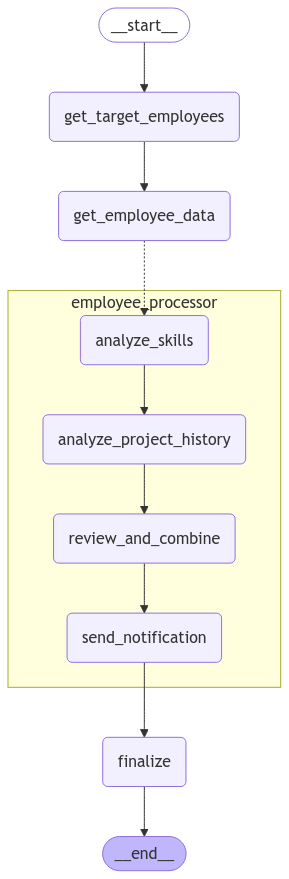

In [16]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))